In [266]:
import torch
import torchcde
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import controldiffeq
import math
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions.bernoulli import Bernoulli
from sklearn.model_selection import train_test_split


In [61]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    def forward(self, z):
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimensions, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(*z.shape[:-1], self.hidden_channels, self.input_channels)
        return z


######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NeuralCDE, self).__init__()
        self.hidden_channels = hidden_channels

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)

    def forward(self, times, coeffs):
        spline = controldiffeq.NaturalCubicSpline(times, coeffs)

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        z0 = self.initial(spline.evaluate(times[0]))

        ######################
        # Actually solve the CDE.
        ######################
        z_T = controldiffeq.cdeint(dX_dt=spline.derivative,
                                   z0=z0,
                                   func=self.func,
                                   t=times,
                                   atol=1e-2,
                                   rtol=1e-2)
        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
#         z_T = z_T[1]
        pred_y = self.readout(z_T)
        return pred_y

In [203]:
def get_data():
    t = torch.linspace(0., 4 * math.pi, 100)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the 
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(128)
    y[:64] = 1

    perm = torch.randperm(128)
    X = X[perm]
    y = y[perm]

    ######################
    # t is a tensor of times of shape (sequence=100,)
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise respectively.
    ######################
    return t, X, y
    

In [164]:
train_t, train_X, _ = get_data()

######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model = NeuralCDE(input_channels=3, hidden_channels=16, output_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` are some tensors describing the path.
# For most problems, it's advisable to save these coeffs and treat them as the dataset, as this interpolation can take
# a long time.
######################
train_coeffs = controldiffeq.natural_cubic_spline_coeffs(train_t, train_X)

train_dataset = torch.utils.data.TensorDataset(*train_coeffs, train_X)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
for epoch in range(60):
    for batch in train_dataloader:
        *batch_coeffs, batch_X = batch
        pred_X = model(train_t, batch_coeffs).squeeze(-1)
#         batch_TND = batch_X[:, :, 1:].view(pred_X.shape[0], pred_X.shape[1], 2)
        batch_TND = batch_X[:, :, 1:].transpose(0,1)
        loss = torch.nn.functional.mse_loss(pred_X, batch_TND)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

test_t, test_X, test_y = get_data()
test_coeffs = controldiffeq.natural_cubic_spline_coeffs(test_t, test_X)
test_pred_X_TND = model(test_t, test_coeffs).squeeze(-1).detach().numpy()

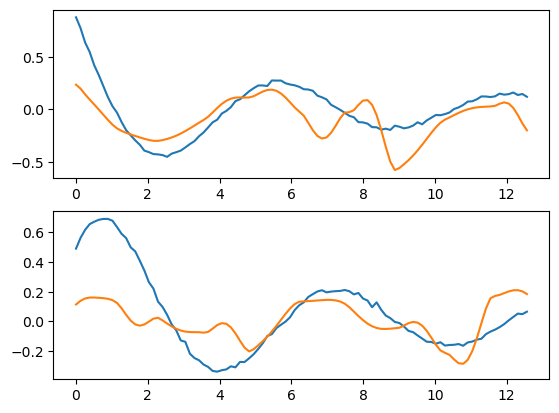

In [165]:
f, axs = plt.subplots(2, 1)
sample_ind = 0
axs[0].plot(test_t, test_X[sample_ind, :, 1], label='true')
axs[0].plot(test_t, test_pred_X_TND[:, sample_ind, 0], label='predicted')

axs[1].plot(test_t, test_X[sample_ind, :, 2], label='true')
axs[1].plot(test_t, test_pred_X_TND[:, sample_ind, 1], label='predicted')

# axs[0].plot(train_t, batch_TND[:, sample_ind, 0], label='true')
# axs[0].plot(train_t, pred_X.detach().numpy()[:, sample_ind, 0], label='predicted')

# axs[1].plot(test_t, batch_TND[:, sample_ind, 1], label='true')
# axs[1].plot(test_t, pred_X.detach().numpy()[:, sample_ind, 1], label='predicted')

# axs[0].legend()
# plt.show()


## Train with toy MNAR data

In [260]:
def get_data_square_sine(n=1000, length=50, obs_proba=0.0006):
    P=25
    D=12
    X_list, X_clean_list, obs_values, ground_truth, obs_times, masks = [], [], [], [], [], []
    sampling_rate = 25
    for i in range(n):
        t_raw = np.arange(length)
        np.random.seed(i)
        b = np.random.uniform(0, 50, 1)
        t1 = t_raw/sampling_rate
        t2 = t_raw/sampling_rate

        f1 = (np.ceil(t1*sampling_rate)+b)%P < D
        mask_0 = f1<.5
        mask_1 = f1>.5
        freq=2
        phase = b/sampling_rate
        f2_clean = mask_1*np.sin(2*np.pi*freq*t2+phase)+mask_0*np.cos(2*np.pi*freq*t2+phase)*0.4
        f2 = f2_clean
        
        ## Add MNAR missingness
        torch.manual_seed(i)
        mnar_lims = [-.4, .4]
        m1 = np.asarray(Bernoulli(torch.tensor(0.6)).sample(f1.shape)) ## Get some irregularly sampled time points
        mnar_inds_1 = np.logical_or(f1<mnar_lims[0], f1>mnar_lims[1])
        miss_1 = np.asarray(Bernoulli(torch.tensor(obs_proba)).sample(f1.shape))
        m1[mnar_inds_1] = miss_1[mnar_inds_1]
        
        # mask obs greater than 1.5 for extrapolation
        m1[t1>=1.5]=0
        
        f1_w_missing = f1.copy()
        f1_w_missing[m1==0]=np.nan
        
        m2 = np.asarray(Bernoulli(torch.tensor(0.6)).sample(f2.shape)) ## Get some irregularly sampled time points
        mnar_inds_2 = np.logical_or(f2<mnar_lims[0], f2>mnar_lims[1])
        miss_2 = np.asarray(Bernoulli(torch.tensor(obs_proba)).sample(f2.shape))
        m2[mnar_inds_2] = miss_2[mnar_inds_2]
        # mask obs greater than 1.5 for extrapolation
        m2[t2>=1.5]=0
        
        masks.append(np.stack((m1, m2), axis=0).T)
        
        f2_w_missing = f2.copy()
        f2_w_missing[m2==0]=np.nan
        
        obs_times.append(np.stack((t1, t2), axis=0))
        obs_values.append(np.stack((f1, f2), axis=0))
#         X_list.append(np.stack((t1, f1*m1, f2*m2), axis=0).T)
        X_list.append(np.stack((t1, f1_w_missing, f2_w_missing), axis=0).T)
        X_clean_list.append(np.stack((t1, f1, f2), axis=0).T)
        
        X = torch.from_numpy(np.array(X_list)).float()
        X_clean = torch.from_numpy(np.array(X_clean_list)).float()
        
        t = torch.from_numpy(t1).float()
        
    return t, X, X_clean, torch.from_numpy(np.array(masks))

In [323]:
# train_t_ss, train_X_ss, _, _ = get_data_square_sine()
t_ss, X_ss, X_clean_ss, mask_ss = get_data_square_sine()
t_ss, X_ss, X_clean_ss, mask_ss = get_data_square_sine()
train_X_ss, test_X_ss, train_X_clean_ss, test_X_clean_ss, train_mask_ss, test_mask_ss = train_test_split(X_ss, 
                                                                                                         X_clean_ss, 
                                                                                                         mask_ss, 
                                                                                                         test_size=0.2,
                                                                                                         shuffle=False)
train_t_ss = t_ss
######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model = NeuralCDE(input_channels=3, hidden_channels=16, output_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` are some tensors describing the path.
# For most problems, it's advisable to save these coeffs and treat them as the dataset, as this interpolation can take
# a long time.
######################
train_coeffs = controldiffeq.natural_cubic_spline_coeffs(train_t_ss, train_X_ss)

train_dataset = torch.utils.data.TensorDataset(*train_coeffs, train_X_ss)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
for epoch in range(100):
    for batch in train_dataloader:
        *batch_coeffs, batch_X = batch
        pred_X = model(train_t_ss, batch_coeffs).squeeze(-1)
#         batch_TND = batch_X[:, :, 1:].view(pred_X.shape[0], pred_X.shape[1], 2)
        batch_TND = batch_X[:, :, 1:].transpose(0,1)
    
        non_nan_inds = torch.logical_not(torch.isnan(batch_TND))
        loss = torch.nn.functional.mse_loss(pred_X[non_nan_inds], batch_TND[non_nan_inds])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))


test_t_ss = t_ss
# test_t_ss, test_X_ss, test_X_clean_ss, test_mask_ss = get_data_square_sine()
test_coeffs = controldiffeq.natural_cubic_spline_coeffs(test_t_ss, test_X_ss)
test_pred_X_TND = model(test_t_ss, test_coeffs).squeeze(-1).detach().numpy()

Epoch: 0   Training loss: 1.2861932516098022
Epoch: 1   Training loss: 0.8457479476928711
Epoch: 2   Training loss: 0.6675505042076111
Epoch: 3   Training loss: 0.5337476134300232
Epoch: 4   Training loss: 0.5623024702072144
Epoch: 5   Training loss: 0.5059518814086914
Epoch: 6   Training loss: 0.5091546177864075
Epoch: 7   Training loss: 0.4904058277606964
Epoch: 8   Training loss: 0.43888160586357117
Epoch: 9   Training loss: 0.3490058183670044
Epoch: 10   Training loss: 0.43830427527427673
Epoch: 11   Training loss: 0.4505046010017395
Epoch: 12   Training loss: 0.46897247433662415
Epoch: 13   Training loss: 0.34893539547920227
Epoch: 14   Training loss: 0.20394544303417206
Epoch: 15   Training loss: 0.18464113771915436
Epoch: 16   Training loss: 0.1787581741809845
Epoch: 17   Training loss: 0.15860795974731445
Epoch: 18   Training loss: 0.16907982528209686
Epoch: 19   Training loss: 0.1528855860233307
Epoch: 20   Training loss: 0.1126367598772049
Epoch: 21   Training loss: 0.1359236

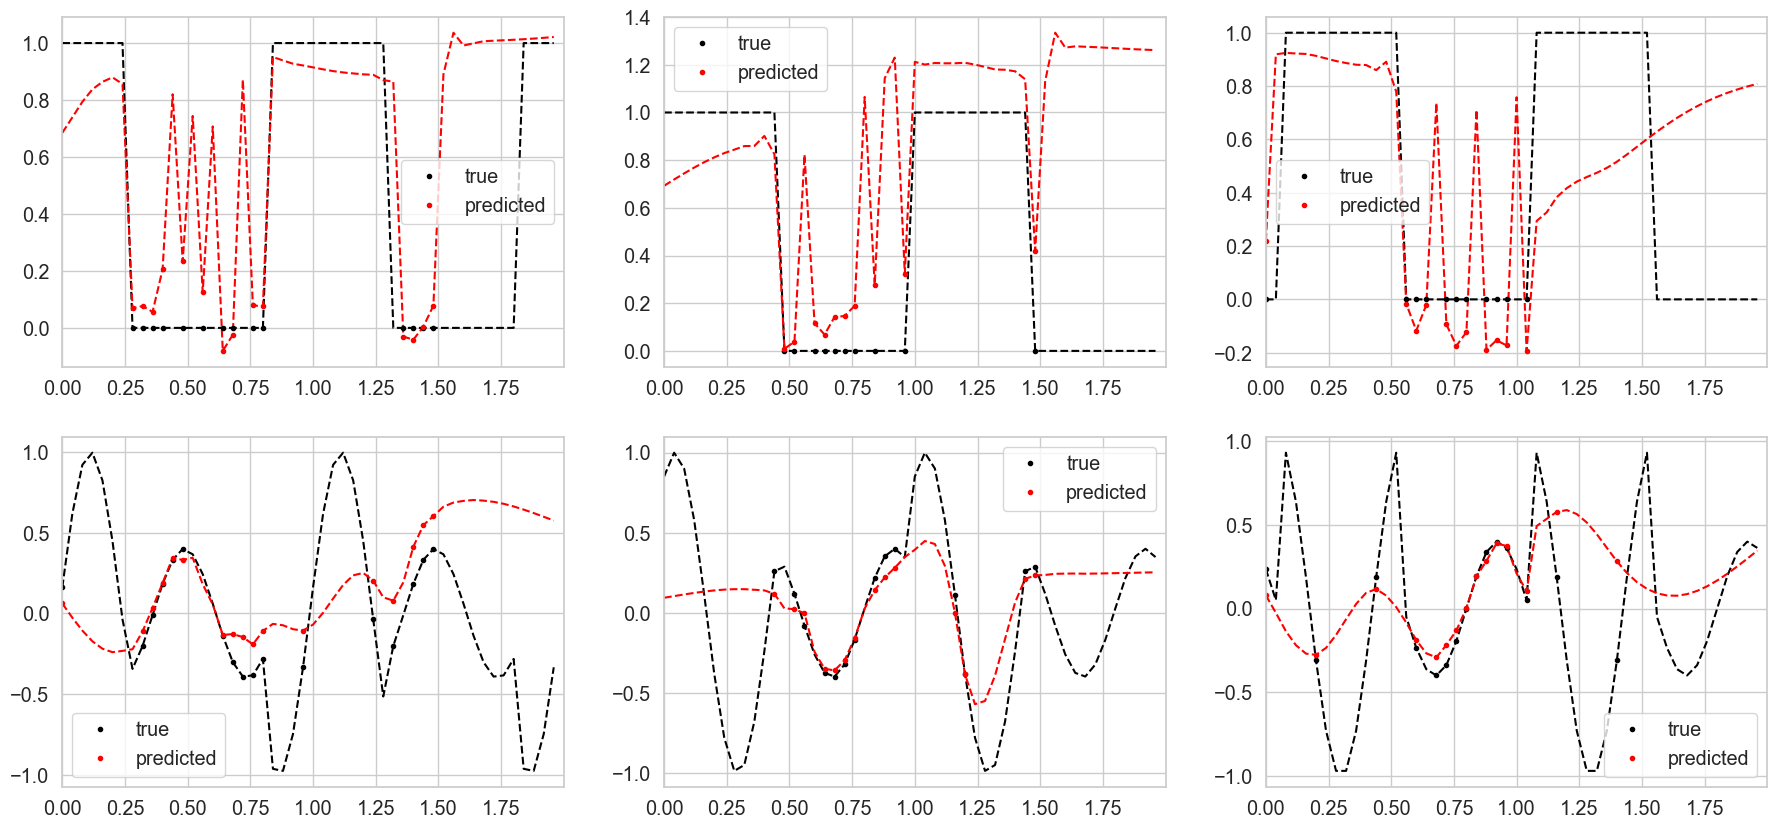

In [324]:
n_plot_seqs = 3
f, axs = plt.subplots(2, n_plot_seqs, figsize=(22, 10))
sns.set_style("whitegrid") # or use "white" if we don't want grid lines
sns.set_context("notebook", font_scale=1.3)

for sample_ind in range(n_plot_seqs):
    axs[0, sample_ind].plot(test_t_ss, 
                test_X_clean_ss[sample_ind, :, 1], 'k--')

    axs[0, sample_ind].plot(test_t_ss, 
                test_pred_X_TND[:, sample_ind, 0], 'r--')

    plot_0_inds = test_mask_ss[sample_ind, :, 0]==1

    axs[0, sample_ind].plot(test_t_ss[plot_0_inds], 
                test_X_ss[sample_ind, :, 1][plot_0_inds], 'k.',
                label='true')

    axs[0, sample_ind].plot(test_t_ss[plot_0_inds], 
                test_pred_X_TND[:, sample_ind, 0][plot_0_inds], 'r.',
                label='predicted')

    axs[0, sample_ind].set_xticks(np.arange(0, 2, .25))
    axs[0, sample_ind].set_xlim([0, 2])

    axs[1, sample_ind].plot(test_t_ss, 
                test_X_clean_ss[sample_ind, :, 2], 'k--')
    axs[1, sample_ind].plot(test_t_ss, 
                test_pred_X_TND[:, sample_ind, 1], 'r--')

    plot_1_inds = test_mask_ss[sample_ind, :, 1]==1

    axs[1, sample_ind].plot(test_t_ss[plot_1_inds], 
                test_X_ss[sample_ind, :, 2][plot_1_inds], 
                'k.',
                label='true')
    axs[1, sample_ind].plot(test_t_ss[plot_1_inds], 
                test_pred_X_TND[:, sample_ind, 1][plot_1_inds], 
                'r.',
                label='predicted')

    axs[1, sample_ind].set_xticks(np.arange(0, 2, .25))
    axs[1, sample_ind].set_xlim([0, 2])

    
    axs[0, sample_ind].legend()
    axs[1, sample_ind].legend()
f.savefig('results/true_vs_predicted_neural_cde.png')

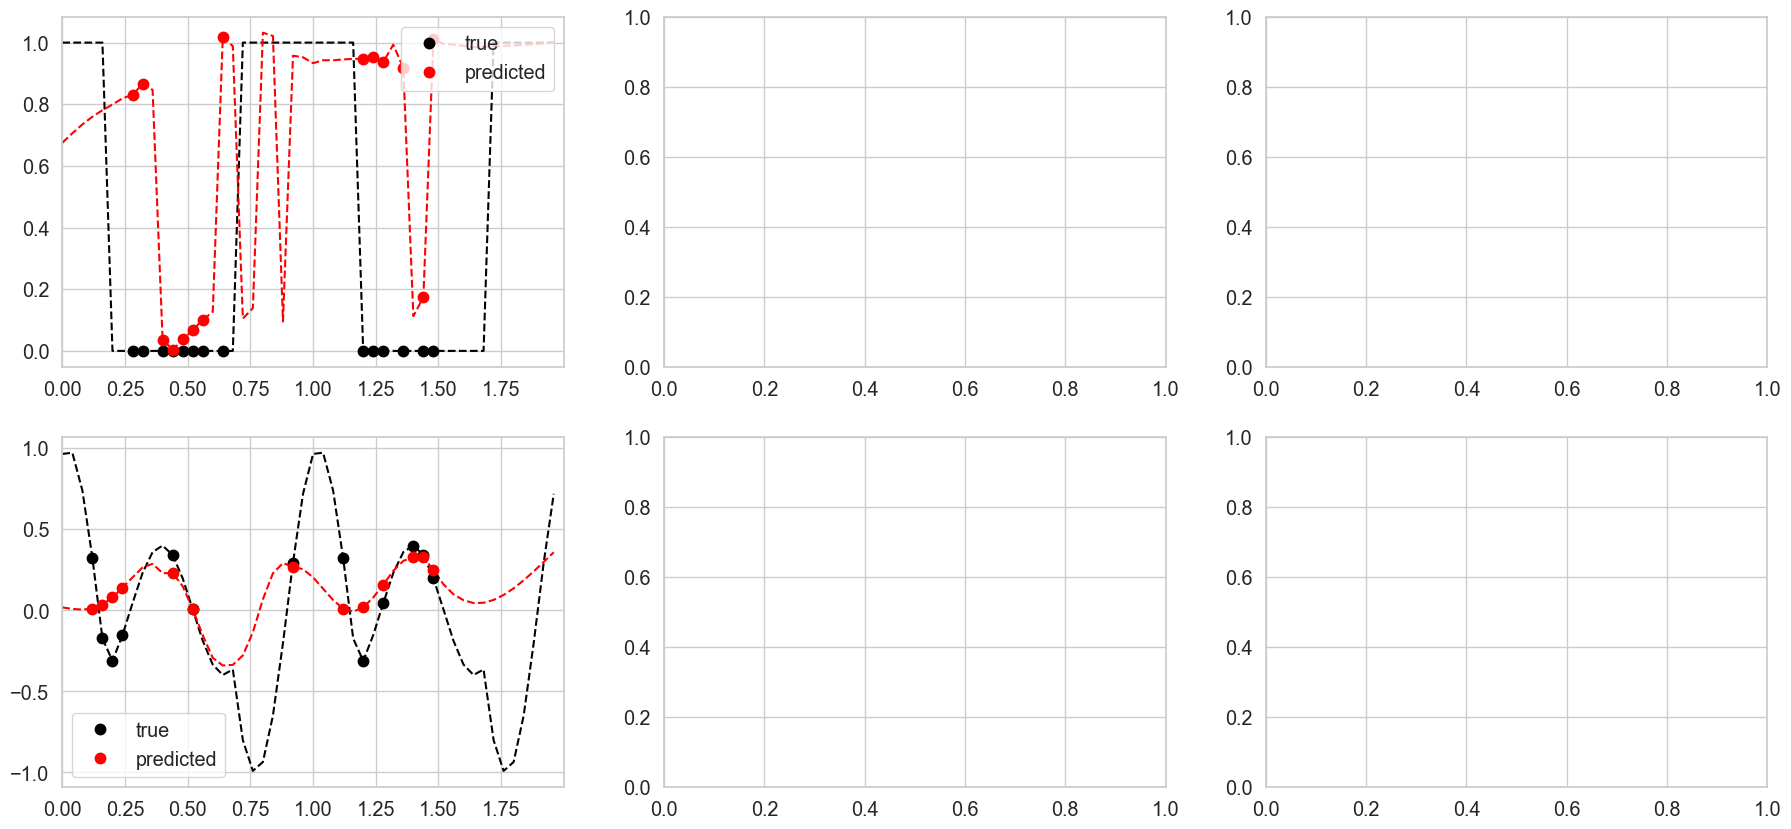

In [337]:
# plot on the single evaluation sequence from CRU
eval_t_ss = t_ss
eval_X_data = np.load('eval_seq_data_TD.npz.npy')
eval_mask_data = np.load('eval_seq_mask_TD.npz.npy')
eval_X_clean_ss = torch.from_numpy(np.transpose(np.stack((eval_t_ss, eval_X_data[:,0], eval_X_data[:, 1]), axis=0)[np.newaxis, :, :], 
                         (0, 2, 1))).float()

eval_X_data[eval_mask_data==0]=np.nan
eval_X_ss = torch.from_numpy(np.transpose(np.stack((eval_t_ss, eval_X_data[:,0], eval_X_data[:, 1]), axis=0)[np.newaxis, :, :], 
                         (0, 2, 1))).float()

eval_mask_ss = torch.from_numpy(eval_mask_data[np.newaxis, :, :]).float()

# eval_X_clean_ss = eval_X_ss
eval_coeffs = controldiffeq.natural_cubic_spline_coeffs(eval_t_ss, eval_X_ss)
eval_pred_X_TND = model(eval_t_ss, train_coeffs).squeeze(-1).detach().numpy()

n_plot_seqs = 3
f, axs = plt.subplots(2, n_plot_seqs, figsize=(22, 10))
sns.set_style("whitegrid") # or use "white" if we don't want grid lines
sns.set_context("notebook", font_scale=1.3)

markersize=15
# for sample_ind in range(n_plot_seqs):
sample_ind = 0
axs[0, sample_ind].plot(eval_t_ss, 
            eval_X_clean_ss[sample_ind, :, 1], 'k--')

axs[0, sample_ind].plot(eval_t_ss, 
            eval_pred_X_TND[:, sample_ind, 0], 'r--')

plot_0_inds = eval_mask_ss[sample_ind, :, 0]==1

axs[0, sample_ind].plot(eval_t_ss[plot_0_inds], 
            eval_X_ss[sample_ind, :, 1][plot_0_inds], 'k.', markersize=markersize,
            label='true')

axs[0, sample_ind].plot(eval_t_ss[plot_0_inds], 
            eval_pred_X_TND[:, sample_ind, 0][plot_0_inds], 'r.',markersize=markersize,
            label='predicted')

axs[0, sample_ind].set_xticks(np.arange(0, 2, .25))
axs[0, sample_ind].set_xlim([0, 2])

axs[1, sample_ind].plot(eval_t_ss, 
            eval_X_clean_ss[sample_ind, :, 2], 'k--')
axs[1, sample_ind].plot(eval_t_ss, 
            eval_pred_X_TND[:, sample_ind, 1], 'r--')

plot_1_inds = eval_mask_ss[sample_ind, :, 1]==1

axs[1, sample_ind].plot(eval_t_ss[plot_1_inds], 
            eval_X_ss[sample_ind, :, 2][plot_1_inds], 
            'k.', markersize=markersize,
            label='true')
axs[1, sample_ind].plot(eval_t_ss[plot_1_inds], 
            eval_pred_X_TND[:, sample_ind, 1][plot_1_inds], 
            'r.', markersize=markersize,
            label='predicted')

axs[1, sample_ind].set_xticks(np.arange(0, 2, .25))
axs[1, sample_ind].set_xlim([0, 2])


axs[0, sample_ind].legend(loc='upper right')
axs[1, sample_ind].legend()
f.savefig('results/true_vs_predicted_neural_cde_single_seq.png', dpi=300)

In [271]:
t_ss, X_ss, X_clean_ss, mask_ss = get_data_square_sine()
train_X_ss, test_X_ss, train_X_clean_ss, test_X_clean_ss, train_mask_ss, test_mask_ss = train_test_split(X_ss, X_clean_ss, mask_ss, test_size=0.2, shuffle=False)

In [304]:
test_t_ss = t_ss
# test_t_ss, test_X_ss, test_X_clean_ss, test_mask_ss = get_data_square_sine()
test_coeffs = controldiffeq.natural_cubic_spline_coeffs(test_t_ss, test_X_ss)
test_pred_X_TND = model(test_t_ss, test_coeffs).squeeze(-1).detach().numpy()

In [307]:
test_X_ss.shape

torch.Size([200, 50, 3])

In [295]:
eval_X_ss.shape

(1, 50, 3)

In [300]:
eval_X_ss.dtype

torch.float64

In [303]:
eval_pred_X_TND.shape

(50, 1, 2)

In [306]:
test_pred_X_TND.shape

(50, 200, 2)

In [311]:
test_mask_ss.dtype

torch.float32

In [315]:
eval_X_ss.shape

torch.Size([1, 50, 3])

In [328]:
eval_coeffs[0].shape

torch.Size([1, 49, 3])